In [1]:
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from utils import *
from PIL import Image
import numpy as np
import sys

import torch
from torch import nn
from torch.autograd import Variable, Function
from torchvision import models, transforms
import torchvision.models as models

%matplotlib inline

print("mpl backend: ", plt.get_backend())

mpl backend:  module://ipykernel.pylab.backend_inline


In [68]:
?? vgg16_pretrained.forward()

In [2]:
vgg16_pretrained = models.vgg16(pretrained=True).eval().cuda()

class VGG16_conv(torch.nn.Module):
    def __init__(self, n_classes):
        super(VGG16_conv, self).__init__()
        # VGG16 (using return_indices=True on the MaxPool2d layers)
        self.features = torch.nn.Sequential(
            # conv1
            torch.nn.Conv2d(3, 64, 3, padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(64, 64, 3, padding=1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv2
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(128, 128, 3, padding=1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv3
            torch.nn.Conv2d(128, 256, 3, padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv4
            torch.nn.Conv2d(256, 512, 3, padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True),
            # conv5
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(512, 512, 3, padding=1),
            torch.nn.ReLU(True),
            torch.nn.MaxPool2d(2, stride=2, return_indices=True))
        self.feature_outputs = [0]*len(self.features)
        self.pool_indices = dict()

        self.classifier = vgg16_pretrained.classifier
        self._initialize_weights()


    def _initialize_weights(self):
        # initializing weights using ImageNet-trained model from PyTorch
        for i, layer in enumerate(vgg16_pretrained.features):
            print("initializing layer {}: {}".format(i, layer))
            try:
                self.features[i].weight.data = layer.weight.data
                self.features[i].bias.data = layer.bias.data
            except:
                continue

    def get_conv_layer_indices(self):
        return [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]

    def forward_features(self, x):
        output = x
        for i, layer in enumerate(self.features):
            if isinstance(layer, torch.nn.MaxPool2d):
                output, indices = layer(output)
                self.feature_outputs[i] = output
                self.pool_indices[i] = indices
            else:
                output = layer(output)
                self.feature_outputs[i] = output
        return output

    def forward(self, x):
        x = self.forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class VGG16_deconv(torch.nn.Module):
    def __init__(self):
        super(VGG16_deconv, self).__init__()
        self.conv2DeconvIdx = {0:17, 2:16, 5:14, 7:13, 10:11, 12:10, 14:9, 17:7, 19:6, 21:5, 24:3, 26:2, 28:1}
        self.conv2DeconvBiasIdx = {0:16, 2:14, 5:13, 7:11, 10:10, 12:9, 14:7, 17:6, 19:5, 21:3, 24:2, 26:1, 28:0}
        self.unpool2PoolIdx = {15:4, 12:9, 8:16, 4:23, 0:30}
        
        self.deconv_features = torch.nn.Sequential(
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(512, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(512, 256, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(256, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(256, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(256, 128, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(128, 128, 3, padding=1),
            torch.nn.ConvTranspose2d(128, 64, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(64, 64, 3, padding=1),
            torch.nn.ConvTranspose2d(64, 3, 3, padding=1))

        # not the most elegant, given that I don't need the MaxUnpools here
        self.deconv_first_layers = torch.nn.ModuleList([
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 512, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 256, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 256, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 128, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 128, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 64, 3, padding=1),
            torch.nn.MaxUnpool2d(2, stride=2),
            torch.nn.ConvTranspose2d(1, 64, 3, padding=1),
            torch.nn.ConvTranspose2d(1, 3, 3, padding=1) ])

        self._initialize_weights()

    def _initialize_weights(self):
        # initializing weights using ImageNet-trained model from PyTorch
        for i, layer in enumerate(vgg16_pretrained.features):
            if isinstance(layer, torch.nn.Conv2d):
                self.deconv_features[self.conv2DeconvIdx[i]].weight.data = layer.weight.data
                biasIdx = self.conv2DeconvBiasIdx[i]
                if biasIdx > 0:
                    self.deconv_features[biasIdx].bias.data = layer.bias.data
                

    def forward(self, x, layer_number, map_number, pool_indices):
        start_idx = self.conv2DeconvIdx[layer_number]
        if not isinstance(self.deconv_first_layers[start_idx], torch.nn.ConvTranspose2d):
            raise ValueError('Layer '+str(layer_number)+' is not of type Conv2d')
        # set weight and bias
        self.deconv_first_layers[start_idx].weight.data = self.deconv_features[start_idx].weight[map_number].data[None, :, :, :]
        self.deconv_first_layers[start_idx].bias.data = self.deconv_features[start_idx].bias.data        
        # first layer will be single channeled, since we're picking a particular filter
        output = self.deconv_first_layers[start_idx](x)

        # transpose conv through the rest of the network
        for i in range(start_idx+1, len(self.deconv_features)):
            if isinstance(self.deconv_features[i], torch.nn.MaxUnpool2d):
                output = self.deconv_features[i](output, pool_indices[self.unpool2PoolIdx[i]])
            else:
                output = self.deconv_features[i](output)
        return output


In [3]:
def vis_layer(activ_map, sh):
    plt.clf()
    plt.subplot(121)
    h = np.int(np.sqrt(sh[1]))
    plt.xticks([i*sh[3]+i+sh[3]/2 for i in range(h)], [i for i in range(h)])
    plt.yticks([i*sh[3]+i+sh[3]/2 for i in range(h)], [i for i in range(h)])
    plt.imshow(activ_map[:,:,0], cmap='gray')

def decon_img(layer_output):
    raw_img = layer_output.data.cpu().numpy()[0].transpose(1,2,0)
    img = (raw_img-raw_img.min())/(raw_img.max()-raw_img.min())*255
    img = img.astype(np.uint8)
    return img

In [4]:
torch.cuda.set_device(3)

n_classes = 1000 # using ImageNet pretrained weights

vgg16_c = VGG16_conv(n_classes).cuda()
conv_layer_indices = vgg16_c.get_conv_layer_indices()
print('VGG16 model:')
print(vgg16_c)

tmp = "".join(open("../labels.txt", 'r').readlines()).replace("\n", "")
labeldict = eval(tmp)

initializing layer 0: Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 1: ReLU (inplace)
initializing layer 2: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 3: ReLU (inplace)
initializing layer 4: MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
initializing layer 5: Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 6: ReLU (inplace)
initializing layer 7: Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 8: ReLU (inplace)
initializing layer 9: MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
initializing layer 10: Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 11: ReLU (inplace)
initializing layer 12: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
initializing layer 13: ReLU (inplace)
initializing layer 14: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

In [21]:
path = "/home/lestsovba/pic/car.jpg"
f = open(path, 'rb')
raw_img = Image.open(f)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
tr = transforms.Compose([
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
        ])

tr_img = tr(raw_img)
img_var = Variable(tr_img, requires_grad=False).unsqueeze(0).cuda()

In [22]:
conv_out = vgg16_c.forward(img_var)
res = nn.Softmax()(conv_out)
prob, ind = torch.topk(res, 5)

for i in range(ind.size()[1]):
    print(labeldict[ind[0][i].data[0]], " : ", prob[0][i].data[0])

sports car, sport car  :  0.7505605816841125
racer, race car, racing car  :  0.2041514813899994
convertible  :  0.025372548028826714
car wheel  :  0.016986951231956482
beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon  :  0.0013186982832849026


(1, 512, 14, 14)


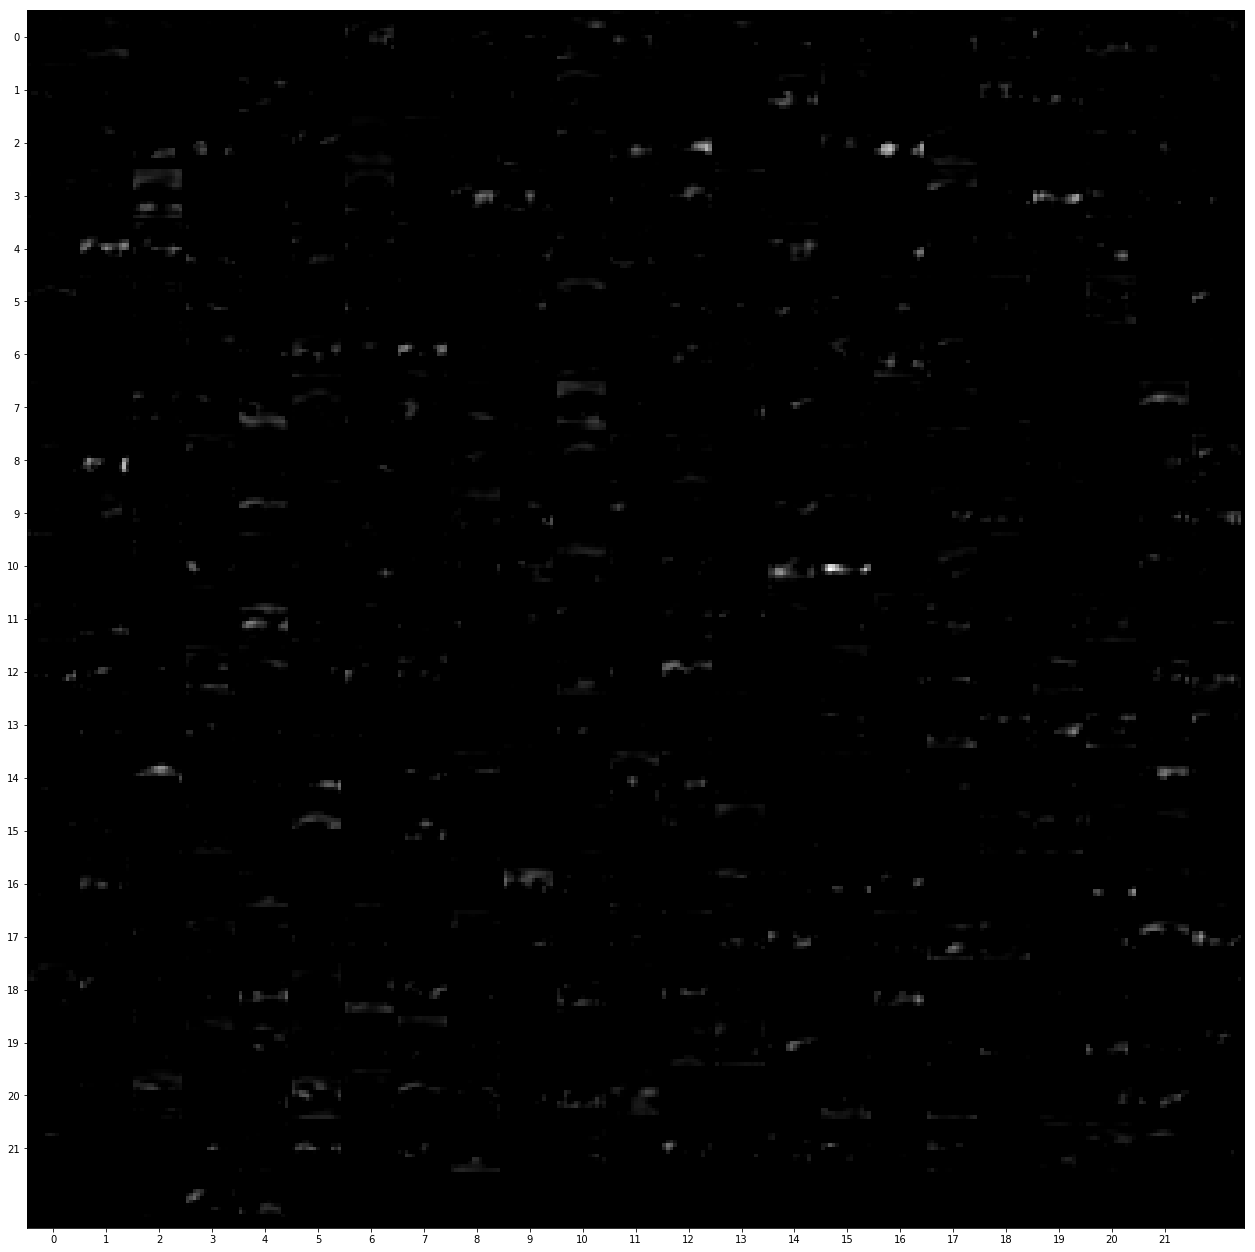

In [24]:
plt.figure(figsize=(48,48))
vgg16_d = VGG16_deconv().cuda()


layer = 28

activ_map = vgg16_c.feature_outputs[layer].data.cpu().numpy()
activ_map_shape = activ_map.shape
print(activ_map_shape)
activ_map = activ_map.transpose(1,2,3,0)
activ_map_grid = vis_grid(activ_map)
vis_layer(activ_map_grid, activ_map_shape)

Maps in layer 28: 512
Map 22:


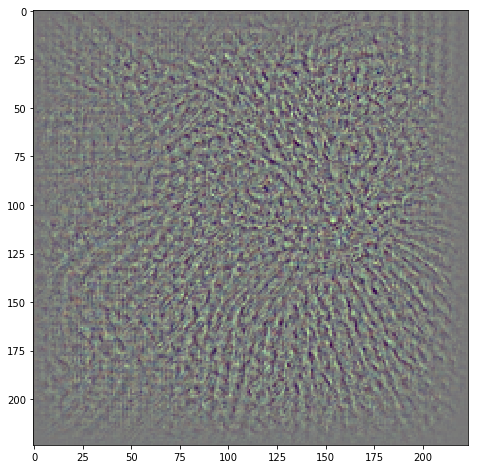

In [20]:
# only transpose convolve from Conv2d or ReLU layers
conv_layer = layer

n_maps = activ_map.shape[0]
print("Maps in layer {}:".format(conv_layer), n_maps)


_, map_x_dim, map_y_dim, _ = activ_map.shape
map_img_x_dim, map_img_y_dim, _ = activ_map_grid.shape
x_step = map_img_x_dim//(map_x_dim+1)


x_index = 0
y_index = 1
map_idx = int(x_step*y_index + x_index)
print("Map {}:".format(map_idx))

if map_idx >= n_maps:
    print('Invalid map selected')

decon = vgg16_d(vgg16_c.feature_outputs[layer][0][map_idx][None,None,:,:], conv_layer, map_idx, vgg16_c.pool_indices)
plt.figure(figsize=(8,8))
img = decon_img(decon)
plt.imshow(img)
